In [1]:
%matplotlib inline
import importlib.util

In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import backtrader as bt
from datetime import datetime

In [3]:
spec = importlib.util.spec_from_file_location("PandasRepo", "/Users/dennis/PycharmProjects/IbTrader/ibtrader/PandasRepo.py")
PandasRepoModule = importlib.util.module_from_spec(spec)
spec.loader.exec_module(PandasRepoModule)

In [4]:
class SectorRotationStrategy(bt.Strategy):

    def __init__(self,
                 fastSmaDays = 40,
                 slowSmaDays = 200):
        self.maxNumPositions = 6
        self.momentum = dict()
        for symbol in self.getdatanames():
            data = self.getdatabyname(symbol)
            smaFast = bt.ind.SMA(data, period=fastSmaDays)
            smaSlow = bt.ind.SMA(data, period=slowSmaDays)
            self.momentum[symbol] = smaFast/smaSlow

    def next(self):
        momentums = dict()
        for symbol in self.getdatanames():
            momentums[symbol] = self.momentum[symbol][0]

        buyThreshold = sorted(momentums.values())[-min(self.maxNumPositions, len(momentums))]
        symbolsToBuy = {k: v for k, v in momentums.items() if v >= buyThreshold}
        pct = 1.0 / len(symbolsToBuy)

        for symbol in self.getdatanames():
            if symbol in symbolsToBuy:
                self.order_target_percent(data=self.getdatabyname(symbol), target=pct)
            else:
                self.order_target_percent(data=self.getdatabyname(symbol), target=0)

In [9]:
class BacktraderWrapper:
    def __init__(self,
                 startCash = 10000,
                 universe = ["IYM", "IYC", "IYK", "IYE", "IYF", "IYH", "IYR", "IYW", "IDU"],
                 startDate = datetime(2007, 1, 2),
                 endDate = datetime(2008, 12, 31)):
        self._startCash = startCash
        self._universe = universe
        self._startDate = startDate
        self._endDate = endDate

    def printSQN(self, analyzer):
        sqn = round(analyzer.sqn,2)
        print('SQN: {}'.format(sqn))
        
    def RunBackTest(self):
        # Create an instance of cerebro
        cerebro = bt.Cerebro()

        # Add our strategy
        cerebro.addstrategy(SectorRotationStrategy)

        # Add data feed
        for symbol in self._universe:
            df = PandasRepoModule.PandasRepo().GetData(symbol, self._startDate, self._endDate)
            data = bt.feeds.PandasData(dataname=df)
            cerebro.adddata(data, name=symbol)

        # Set our desired cash start
        cerebro.broker.setcash(self._startCash)

        # Set up pyfolio
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
        cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")

        # Run over everything
        results = cerebro.run()
        cerebro.plot(style='candlestick')
        
        strat = results[0]
        self.printSQN(strat.analyzers.sqn.get_analysis())
        

        
#         pyfoliozer = strat.analyzers.getbyname('pyfolio')
#         returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
        
#         benchmarkDf = df = PandasRepoModule.PandasRepo().GetData('SPY', self._startDate, self._endDate)
#         benchmarkDf = benchmarkDf['Close'].pct_change().fillna(0).tz_localize(tz='UTC')
#         benchmarkDf.index.name = 'index'
        
#         import matplotlib.pyplot as plt
#         plt.plot(returns)
#         plt.show()
        
#         plt.plot(benchmarkDf)
#         plt.show()

#         import pyfolio as pf
#         pf.create_full_tear_sheet(
#             returns,
#             positions=positions,
#             benchmark_rets = benchmarkDf,
#             transactions=transactions,
#             gross_lev=gross_lev,
#             round_trips=True)

/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/backtrader/plot/plot.py:127: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda3/envs/ipykernel_py3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/envs/ipykernel_py3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages

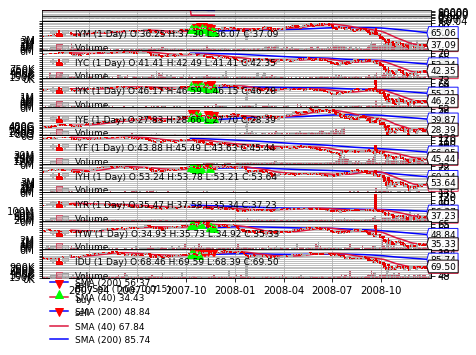

SQN: 0


In [10]:
BacktraderWrapper(startCash=100000).RunBackTest()